#using BeautifulSoup  and requests


In [ ]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from datetime import datetime
import time

In [ ]:



start_time = time.time()

# Create a list that contains the URL for each page.
pages = []

# There are 155 pages in the entire set.
for page_number in range(1, 155):
    url_start = 'https://www.centralcharts.com/en/price-list-ranking/'
    url_end = 'ALL/asc/ts_19-us-nasdaq-stocks--qc_1-alphabetical-order?p='
    url = url_start + url_end + str(page_number)
    pages.append(url)

# Here is the home page URL for reference:
# https://www.centralcharts.com/en/price-list-ranking/ALL/asc/ts_19-us-nasdaq-stocks--qc_1-alphabetical-order?p=1

# Create a list containing the <th> tag contents.
webpage = requests.get(pages[0])
soup = bs(webpage.text, 'html.parser')
stock_table = soup.find('table', class_='tabMini tabQuotes')
th_tag_list = stock_table.find_all('th')


# Take the <th> list and remove the extra attributes to
# get just the text portion of each tag. Use this text for the
# column header labels in the dataframe.
headers = []
for each_tag in th_tag_list:
    title = each_tag.text
    headers.append(title)

headers[0] = 'Name'

new_headers = []
for header in headers:
    if header not in ('Cap.', 'Issued Cap.', ''):
        new_headers.append(header)
headers = new_headers
stock_df = pd.DataFrame(columns = headers)

# Cycle through each page.
for page in pages:
    webpage = requests.get(page)
    soup = bs(webpage.text, 'html.parser')

    # Check to see if the page contains a table. If it does,
    # create a list of <tr> tags. If not, go to the next page.
    if soup.find('table'):
        stock_table = soup.find('table', class_='tabMini tabQuotes')
        tr_tag_list = stock_table.find_all('tr')

        # Cycle through the <tr> list. For each
        # row, find the <td> tags within the row. Then
        # obtain the text within each <td> tag. Lastly,
        # place the text in the last row of the dataframe.
        for each_tr_tag in tr_tag_list[1:]:
            td_tag_list = each_tr_tag.find_all('td')

            row_values = []
            for each_td_tag in td_tag_list[0:7]:
                new_value = each_td_tag.text.strip()
                row_values.append(new_value)

            stock_df.loc[len(stock_df)] = row_values

# Change the data types & sort by trading volume
stock_df[['Name', 'Current price', 'Change(%)', 'Open','High', 'Low']] = \
    stock_df[['Name', 'Current price', 'Change(%)', 'Open', 'High', 'Low']] \
    .astype(str)

stock_df.replace({'Current price': {',':'', '-':'1'},
                  'Change(%)': {',':'', '-':'1', '%':''},
                  'Open': {',':'', '-':'1'},
                  'High': {',':'', '-':'1'},
                  'Low': {',':'', '-':'1'},
                  'Volume': {',':'', '-':'1'}
}, regex=True, inplace=True)

stock_df[['Current price', 'Change(%)', 'Open', 'High', 'Low', 'Volume']] = \
    stock_df[['Current price', 'Change(%)', 'Open', 'High', 'Low', 'Volume']]. \
    apply(pd.to_numeric)

stock_df = stock_df.sort_values(by=['Volume'], ascending=False)

print(stock_df)

# Export the dataframe to a csv file.
stock_df.to_csv('stock_data.csv', index=False)





                            Name  Current price  Change(%)      Open  \
2419              NEXT.E.GO N.V.         0.0512      42.22    0.0412   
112           AGBA GROUP HOLDING         1.2500      21.36    1.4800   
3104     SINTX TECHNOLOGIES INC.         0.0418       4.50    0.0400   
562              BLUE STAR FOODS         0.0760      18.01    0.0615   
2485                NVIDIA CORP.       762.0000     110.00  831.5000   
...                          ...            ...        ...       ...   
189       ALPHA STAR ACQUISITION         1.0000       0.00    1.0000   
2224  METAL SKY STAR ACQUISITION         1.0000       0.00    1.0000   
1928         KAIROUS ACQUISITION         1.0000       0.00    1.0000   
2230            MF INTERNATIONAL         1.0000       0.00    1.0000   
2151  MAQUIA CAPITAL ACQUISITION         1.0000       0.00    1.0000   

          High       Low     Volume  
2419    0.0843    0.0412  333643035  
112     1.6400    1.1500  128778055  
3104    0.0466    0.0

<ipython-input-14-11db6854e23b>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels([f'{x:,.0f}' for x in current_volumes], rotation=45)


--- 569.3058290481567 seconds ---


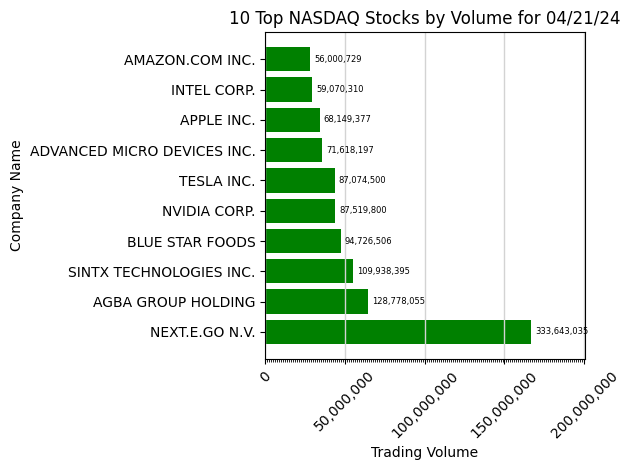

In [ ]:

# Get the top 10 stocks and plot them on a horizontal bar chart
top_10_stock_df = stock_df.head(10)

# y-values
names = top_10_stock_df['Name']
# x-values
volumes = top_10_stock_df['Volume']

# Create the 'fig' object (the outermost section of the image
# that contains the axes object)
fig = plt.figure()

# Create the 'ax' object (found within the 'fig' object and
# contains the axes, labels, and the actual plot
ax = plt.subplot()

# Create the 'bar_plot' object, add the data and bar labels
bar_plot = ax.barh(names, volumes, color='green')
# Group each bar label in a 'container'. Format each data value with a
# comma every 3 digits.
container = ax.containers[0]
ax.bar_label(container, labels=[f'{x:,.0f}' for x in container.datavalues],
    fontsize=6, padding=3)
current_volumes = plt.gca().get_xticks()
plt.gca().set_xticklabels([f'{x:,.0f}' for x in current_volumes], rotation=45)

# Add a title and axis labels
ax.set_xlabel('Trading Volume')
ax.set_ylabel('Company Name')
now = datetime.now()
todays_date = now.strftime('%m/%d/%y')
ax.set_title('10 Top NASDAQ Stocks by Volume for ' + todays_date)

# Some formatting to give the labels proper padding
plt.tight_layout()
ax.set_xmargin(0.2)

# Add extra tick marks every 2.5 million
ax.xaxis.set_minor_locator(MultipleLocator(2500000))

# Add major gridlines
ax.grid(which='major', axis='x', color='lightgrey', linestyle='-', linewidth='1')

print("--- %s seconds ---" % (time.time() - start_time))

# Show the plot
plt.show()

# https://matplotlib.org/stable/tutorials/intermediate/tight_layout_guide.html
# ^ good reference for subplots

In [ ]:
stock_df

,Name,Current price,Change(%),Open,High,Low,Volume
2419,NEXT.E.GO N.V.,0.0512,42.22,0.0412,0.0843,0.0412,333643035
112,AGBA GROUP HOLDING,1.2500,21.36,1.4800,1.6400,1.1500,128778055
3104,SINTX TECHNOLOGIES INC.,0.0418,4.50,0.0400,0.0466,0.0340,109938395
562,BLUE STAR FOODS,0.0760,18.01,0.0615,0.0961,0.0603,94726506
2485,NVIDIA CORP.,762.0000,110.00,831.5000,843.2400,756.0600,87519800
...,...,...,...,...,...,...,...
189,ALPHA STAR ACQUISITION,1.0000,0.00,1.0000,1.0000,1.0000,1
2224,METAL SKY STAR ACQUISITION,1.0000,0.00,1.0000,1.0000,1.0000,1
1928,KAIROUS ACQUISITION,1.0000,0.00,1.0000,1.0000,1.0000,1
2230,MF INTERNATIONAL,1.0000,0.00,1.0000,1.0000,1.0000,1


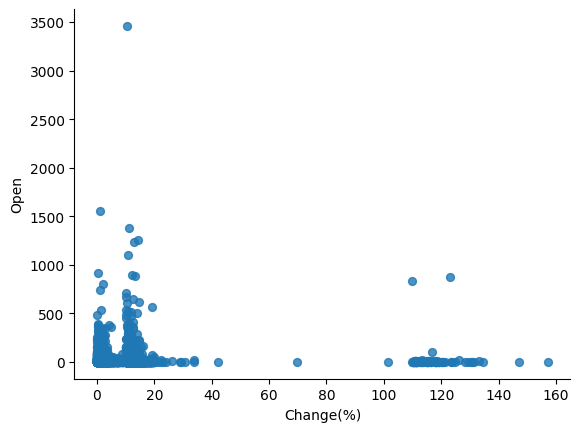

In [ ]:
# @title Change(%) vs Open

from matplotlib import pyplot as plt
stock_df.plot(kind='scatter', x='Change(%)', y='Open', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

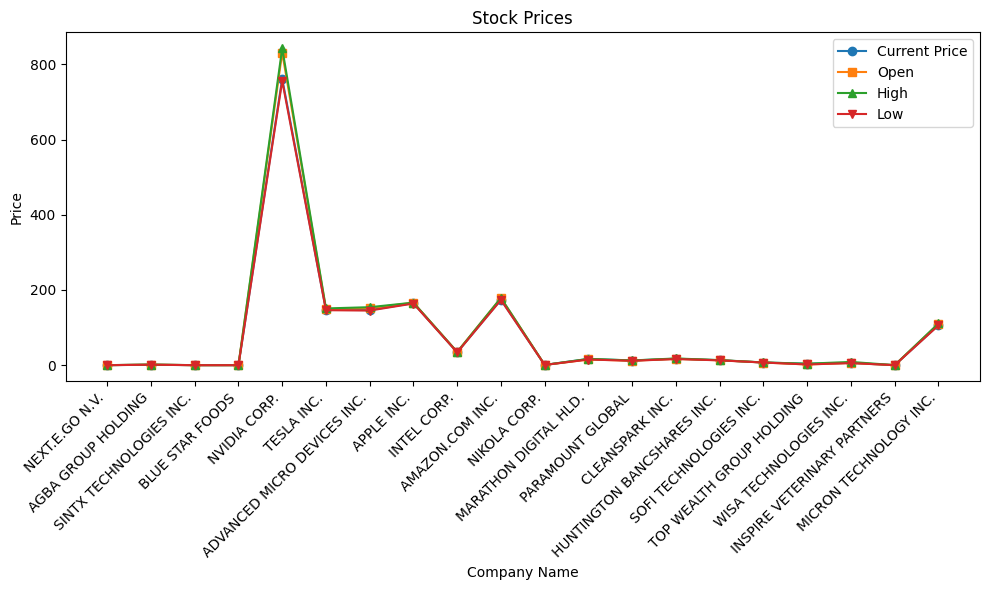

In [ ]:
df=stock_df[:20]
# Plotting curves (line plots)
plt.figure(figsize=(10, 6))
plt.plot(df['Name'], df['Current price'], label='Current Price', marker='o')
plt.plot(df['Name'], df['Open'], label='Open', marker='s')
plt.plot(df['Name'], df['High'], label='High', marker='^')
plt.plot(df['Name'], df['Low'], label='Low', marker='v')
plt.xlabel('Company Name')
plt.ylabel('Price')
plt.title('Stock Prices')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()



#using requests_html

In [ ]:
from requests_html import HTMLSession
import pandas as pd
import time



start_time = time.time()

# Create a list that contains the URL for each page.
pages = []

# There are 155 pages in the entire set.
for page_number in range(1, 155):
    url_start = 'https://www.centralcharts.com/en/price-list-ranking/'
    url_end = 'ALL/asc/ts_19-us-nasdaq-stocks--qc_1-alphabetical-order?p='
    url = url_start + url_end + str(page_number)
    pages.append(url)

# Create a session
session = HTMLSession()

# Create an empty DataFrame
stock_df1 = pd.DataFrame()

# Cycle through each page.
for page in pages:
    response = session.get(page)

    # Check if the page contains a table. If it does,
    # extract data from the table.
    if 'table' in response.html.raw_html.decode():
        stock_table = response.html.find('table.tabMini.tabQuotes', first=True)
        if stock_table:
            rows = stock_table.find('tr')

            for row in rows[1:]:
                columns = row.find('td')
                if columns:
                    row_values = [column.text.strip() for column in columns]
                    if len(row_values) == len(stock_df.columns):
                      stock_df = stock_df1.append(pd.Series(row_values, index=stock_df.columns), ignore_index=True)






In [ ]:

# Rename the columns and change data types as needed
stock_df.columns = ['Name', 'Current price', 'Change(%)', 'Volume', 'Open', 'High', 'Low']
stock_df[['Current price', 'Change(%)', 'Volume', 'Open', 'High', 'Low']] = \
    stock_df[['Current price', 'Change(%)', 'Volume', 'Open', 'High', 'Low']].astype(float)

# Sort by trading volume
stock_df1 = stock_df.sort_values(by=['Volume'], ascending=False)

print(stock_df)

# Export the dataframe to a JSON file.
stock_df.to_json('stock_data.json', orient='records')



                            Name  Current price  Change(%)    Volume  \
2419              NEXT.E.GO N.V.         0.0512      42.22    0.0412   
112           AGBA GROUP HOLDING         1.2500      21.36    1.4800   
3104     SINTX TECHNOLOGIES INC.         0.0418       4.50    0.0400   
562              BLUE STAR FOODS         0.0760      18.01    0.0615   
2485                NVIDIA CORP.       762.0000     110.00  831.5000   
...                          ...            ...        ...       ...   
189       ALPHA STAR ACQUISITION         1.0000       0.00    1.0000   
2224  METAL SKY STAR ACQUISITION         1.0000       0.00    1.0000   
1928         KAIROUS ACQUISITION         1.0000       0.00    1.0000   
2230            MF INTERNATIONAL         1.0000       0.00    1.0000   
2151  MAQUIA CAPITAL ACQUISITION         1.0000       0.00    1.0000   

          Open      High          Low  
2419    0.0843    0.0412  333643035.0  
112     1.6400    1.1500  128778055.0  
3104    0.0466 

In [ ]:
!pip install requests-html


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7


<ipython-input-28-6cf6da687936>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Volume', y='Name', data=top_volume_stocks, palette='viridis')


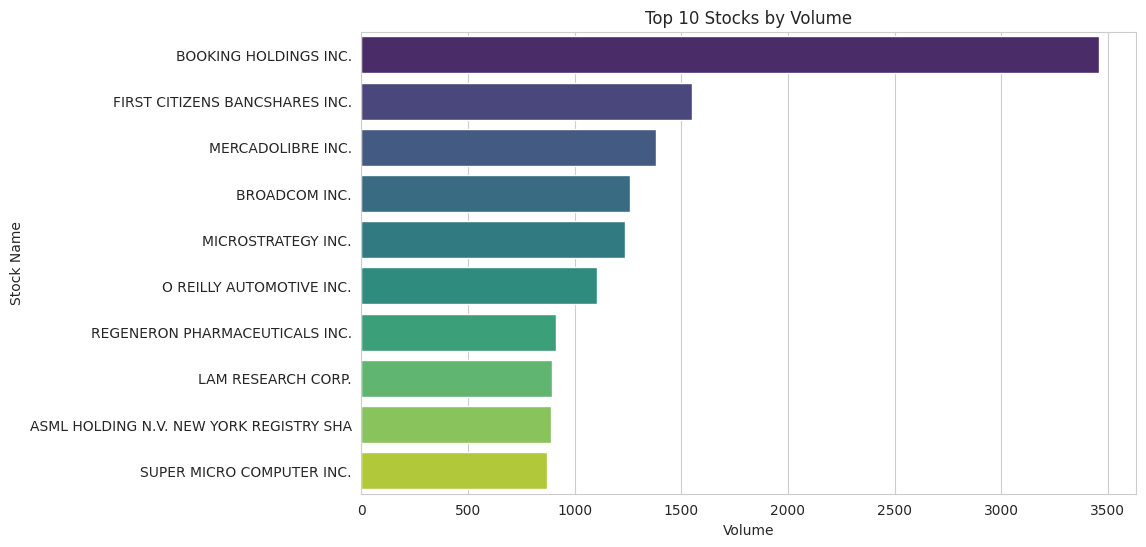

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for seaborn plots
sns.set_style("whitegrid")

# Plotting Top Volume Stocks (Bar Chart)
top_volume_stocks = stock_df.nlargest(10, 'Volume')
plt.figure(figsize=(10, 6))
sns.barplot(x='Volume', y='Name', data=top_volume_stocks, palette='viridis')
plt.title('Top 10 Stocks by Volume')
plt.xlabel('Volume')
plt.ylabel('Stock Name')
plt.show()


<ipython-input-29-b518bf9607fb>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='Current price', y='Change(%)', size='Volume', data=stock_df, palette='coolwarm')


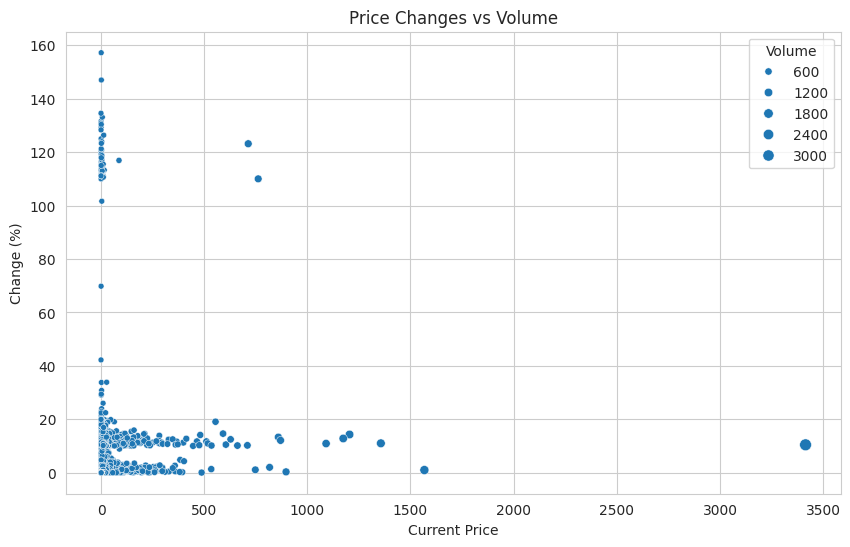

In [ ]:

# Scatter Plot for Price Changes with Volume
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Current price', y='Change(%)', size='Volume', data=stock_df, palette='coolwarm')
plt.title('Price Changes vs Volume')
plt.xlabel('Current Price')
plt.ylabel('Change (%)')
plt.show()


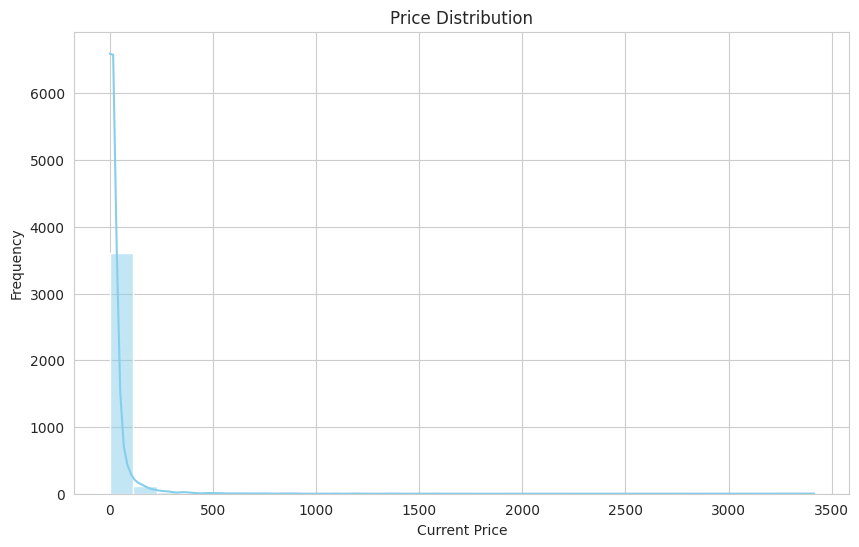

In [ ]:
# Histogram of Price Distribution
plt.figure(figsize=(10, 6))
sns.histplot(stock_df['Current price'], bins=30, kde=True, color='skyblue')
plt.title('Price Distribution')
plt.xlabel('Current Price')
plt.ylabel('Frequency')
plt.show()


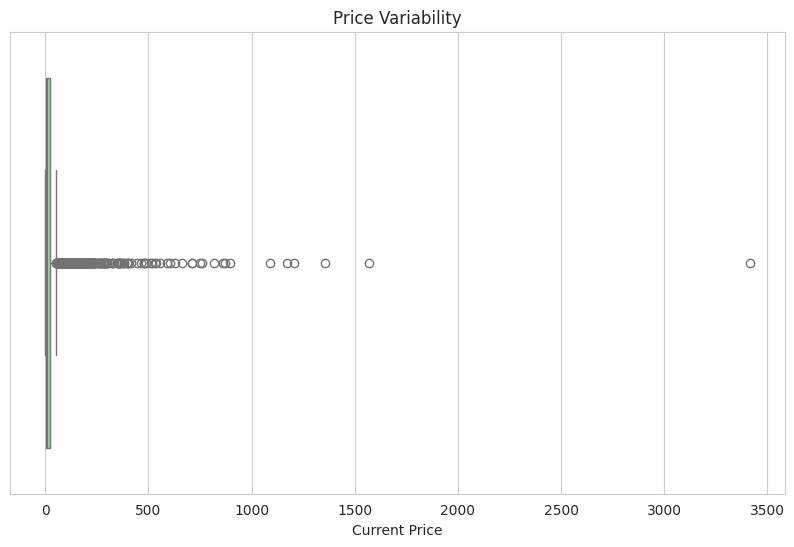

In [ ]:

# Box Plot for Price Variability
plt.figure(figsize=(10, 6))
sns.boxplot(x=stock_df['Current price'], color='lightgreen')
plt.title('Price Variability')
plt.xlabel('Current Price')
plt.show()

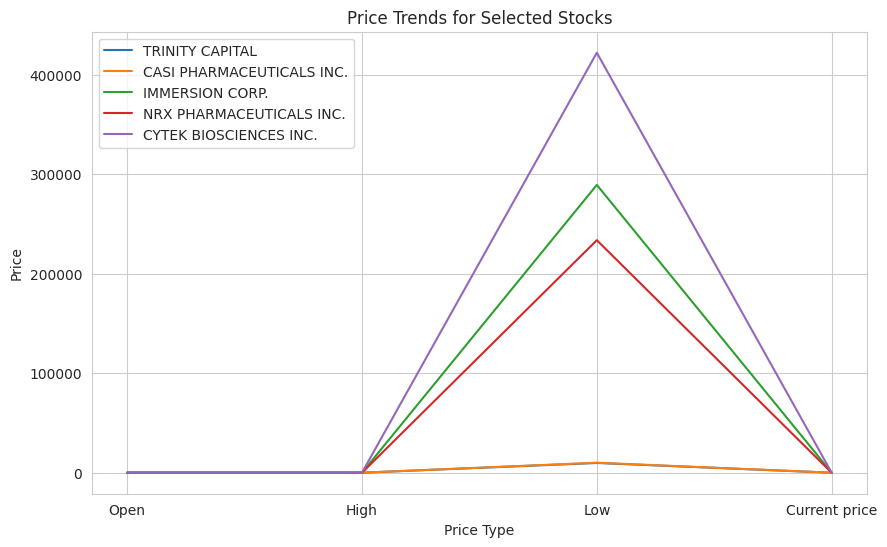

In [ ]:



# Line Plot for Price Trends (Random Selection of 5 Stocks)
plt.figure(figsize=(10, 6))
for index, row in selected_stocks.iterrows():
    plt.plot(['Open', 'High', 'Low', 'Current price'], row[['Open', 'High', 'Low', 'Current price']], label=row['Name'])
plt.title('Price Trends for Selected Stocks')
plt.xlabel('Price Type')
plt.ylabel('Price')
plt.legend()
plt.show()
